In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit
import warnings
import json
from helper_functions import find_dips_robust, find_index
from wafer_plot import draw_wafer_plot

warnings.filterwarnings('ignore')

In [2]:
def lin_func(x, a):
    return a * x

# Find P_pi
def find_p_pi(wavel: list, trans: list[list], elec_pwrs: list, wl_range: list, v_u_id: int) -> float:
    wl_l, wl_u = wl_range[0], wl_range[1]
    l_id, u_id = find_index(wl_l, wavel), find_index(wl_u, wavel)
    
    dips_0V = find_dips_robust(wavel[l_id:u_id], trans[0][l_id:u_id], -35)
    FSR = abs(dips_0V[1] - dips_0V[0])
    wavel_ref = dips_0V[0]
    # print(FSR)
    
    dips = []
    for i in range(v_u_id):
        dips.append(find_dips_robust(wavel[l_id:u_id], trans[i][l_id:u_id], -35))
    # print(dips)
    
    dip = []
    for i in range(v_u_id):
        if i == 0:
            dip.append(dips[0][-1])
            continue
    
        dips[i].reverse()
        # print(dip)
        for d in dips[i]:  # the spectrum moves to the left side as voltages increases
            if d < dip[i-1]:
                dip.append(d)
                break
                
    wavel_shift = np.array([w - dip[0] for w in dip])
    p_opt, p_cov = curve_fit(lin_func, wavel_shift, elec_pwrs[:v_u_id])
    P_pi = lin_func(-FSR, *p_opt)/2
    return P_pi

# fig, ax = plt.subplots(1, 1, figsize=(7, 5))
# ax.plot(wavel_shift, elec_pwrs[:v_u_id], 'o')
# ax.plot(wavel_shift, lin_func(wavel_shift, *p_opt))
# ax.plot(-FSR, 2*P_pi, marker='*', markersize=10, color='r', label='$P_{\pi}$' + f' = {P_pi:.2f} mW\n'+f'FSR = {FSR:.2f} nm')
# ax.set_ylabel('Electrical power (mW)')
# ax.set_xlabel('Wavelength shift (nm)')
# ax.set_title(title)
# ax.legend(prop={'size':12})

In [3]:
# MacBook
root_path = Path('/Users/jiahaozhan/Google Drive/Other Computers/CM300/Dione_wafer3_BO')
data_path = root_path / 'xps_data' / 'therm_phase_si_crossing_test_cells'

no = 0
P_pi_all = {}
FSR_est = 3.4
device_no = 0
v_u_id = 12

data_dir_gen = sorted(data_path.glob(f'reticle*/*.json'))
for d in data_dir_gen:
    df = pd.read_json(d)
    # print(df.columns)
    ret = int(df['reticle'][no])
    print(ret)

    if ret == 0:
        device_no = df['device_no'][no]
        IK_min_width, CA_offset_x, undercut_index = df['IK_min_width'][no], df['CA_offset_x'][no], df['index'][no]
    
    wavel = df['wavelength'][no]
    trans = df['transmission_ch1'][no]
    volts = df['smu_voltage'][no]
    currs = np.multiply(df['smu_current'][no], 1000)
    elec_pwrs = np.multiply(volts, currs)

    wl_l, wl_u = 1305, 1312  # find the pivot dip in this wl range
    l_id, u_id = find_index(wl_l, wavel), find_index(wl_u, wavel)
    dips_0V = find_dips_robust(wavel[l_id:u_id], trans[0][l_id:u_id], -35)
    wl_range = [dips_0V[-1] - 1.5 * FSR_est, dips_0V[-1] + 0.5 * FSR_est]
    # plot_spectra(wavel, trans, ret, wl_range)
    P_pi_all[ret] = find_p_pi(wavel, trans, elec_pwrs, wl_range, v_u_id)

# res = np.divide(volts[1:], np.divide(currs[1:], 1000))

# print(currs)
# print(volts)
print(P_pi_all)

15
25
26
3
33
35
36
39
56
57
60
9
{15: 6.911867008315638, 25: 6.924565842481645, 26: 7.01446000405098, 3: 14.017591440774051, 33: 6.883992015711262, 35: 6.91468735931772, 36: 6.942192723664438, 39: 6.952068401328113, 56: 6.9060811593471625, 57: 6.897131847012169, 60: 6.992941311446557, 9: 6.9535927931787525}


In [4]:
# MacBook
root_path = Path('/Users/jiahaozhan/Google Drive/Other Computers/CM300/Dione_wafer3_BO')
data_path = root_path / 'therm_phase_si_crossing_test_cells_dev43'

no = 0
# P_pi_all = {}
FSR_est = 3.4
device_no = 0
v_u_id = 15

data_dir_gen = sorted(data_path.glob(f'reticle*/*.json'))
for d in data_dir_gen:
    df = pd.read_json(d)
    # print(df.columns)
    ret = int(df['reticle'][no])
    print(ret)

    if ret == 0:
        device_no = df['device_no'][no]
        IK_min_width, CA_offset_x, undercut_index = df['IK_min_width'][no], df['CA_offset_x'][no], df['index'][no]
    
    wavel = df['wavelength'][no]
    trans = df['transmission_ch1'][no]
    volts = df['smu_voltage'][no]
    currs = df['smu_current'][no]
    elec_pwrs = np.multiply(volts, currs)

    wl_l, wl_u = 1305, 1312  # find the pivot dip in this wl range
    l_id, u_id = find_index(wl_l, wavel), find_index(wl_u, wavel)
    dips_0V = find_dips_robust(wavel[l_id:u_id], trans[0][l_id:u_id], -35)
    wl_range = [dips_0V[-1] - 1.5 * FSR_est, dips_0V[-1] + 0.5 * FSR_est]
    # plot_spectra(wavel, trans, ret, wl_range)
    P_pi_all[ret] = find_p_pi(wavel, trans, elec_pwrs, wl_range, v_u_id)

# res = np.divide(volts[1:], np.divide(currs[1:], 1000))

# print(currs)
# print(volts)
print(P_pi_all)

0
1
10
11
12
13
14
16
17
18
19
2
20
21
22
23
24
27
28
29
30
31
32
34
37
38
4
40
41
42
43
44
45
46
47
48
49
5
50
51
52
53
54
55
6
61
62
63
7
8
{15: 6.911867008315638, 25: 6.924565842481645, 26: 7.01446000405098, 3: 14.017591440774051, 33: 6.883992015711262, 35: 6.91468735931772, 36: 6.942192723664438, 39: 6.952068401328113, 56: 6.9060811593471625, 57: 6.897131847012169, 60: 6.992941311446557, 9: 6.9535927931787525, 0: 8.019083465557562, 1: 7.044628900697112, 10: 6.95592975677237, 11: 6.866395652783124, 12: 6.874023660299034, 13: 6.8741189843923625, 14: 6.915236985568897, 16: 7.023360149774386, 17: 6.910594663517501, 18: 6.915404882954378, 19: 6.997661110138003, 2: 6.932567457899919, 20: 7.026573849517172, 21: 6.955461486523284, 22: 6.911001932603813, 23: 6.917226538099709, 24: 6.972120461404257, 27: 6.956860022537981, 28: 6.981196431125872, 29: 6.998672525448564, 30: 6.909504148223742, 31: 6.9194232332989385, 32: 6.881941634801358, 34: 6.946078377762015, 37: 7.021735401762682, 38: 6.916

In [36]:
# plot tranmission spectra at different voltages
def plot_spectra(wavel: list, trans: list, ret: int, wl_range: list):
    # title = f"xps: IK_min_width {df['IK_min_width'][no]} um, CA_offset_x {df['CA_offset_x'][no]}, undercut_index {df['index'][no]}"
    title = f'Reticle {ret}'
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    for i in [0,2,4,6,8,10,11,12]:
        ax.plot(wavel, trans[i], label=f'{volts[i]:.2} V')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Transmission (dB)')
    ax.set_title(title)
    ax.legend()
    ax.set_xlim(wl_range)
    # ax.text(xlim[1]-2, -61, '$P_{\pi}$ = ' + f'{P_pi:.2f} mW', fontsize=12)

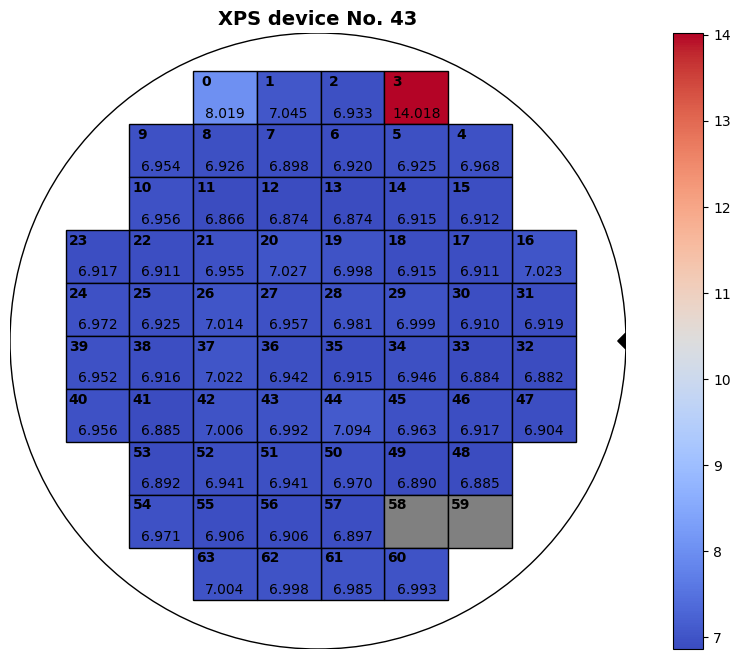

In [5]:
# get wafer plot
title = f'XPS device No. {device_no}'
draw_wafer_plot(data=P_pi_all, title=title)